In [25]:
!pip install yfinance
import numpy as np
import pandas as pd
import warnings
import os
import yfinance as yf

In [26]:
#1년

In [27]:
df = yf.download('014130.KS', start = '2019-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [28]:
df['CODE'] = 'SPY'

In [29]:
price_df = df.loc[:,['Adj Close']].copy()

In [30]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [31]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [32]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [33]:
n = 20 #이평선
sigma = 2 #시그마

In [34]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [35]:
bollinger = bollinger_band(price_df, n, sigma)

In [36]:
base_date = '2009-01-02'

In [37]:
sample = bollinger.loc[base_date:]

In [38]:
book = sample[['Adj Close']].copy()

In [39]:
book['trade'] = '' #거래내역 컬럼

In [40]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [41]:
book = create_trade_book(sample)

In [42]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [43]:
book = tradings(sample,book)

In [44]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2019-03-08 00:00:00 long 진입가격 :  4730.68310546875
청산일 :  2019-04-08 00:00:00 long 진입가격 :  4730.68310546875  |  long 청산가격 :  5281.44873046875  | return: 1.1164
진입일 :  2019-07-05 00:00:00 long 진입가격 :  6550.1767578125
청산일 :  2019-12-30 00:00:00 long 진입가격 :  6550.1767578125  |  long 청산가격 :  4410.0  | return: 0.6733


In [45]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [46]:
print(returns(book))

진입일 :  2019-03-08 00:00:00 long 진입가격 :  4730.68310546875
청산일 :  2019-04-08 00:00:00 long 진입가격 :  4730.68310546875  |  long 청산가격 :  5281.44873046875  | return: 1.1164
진입일 :  2019-07-05 00:00:00 long 진입가격 :  6550.1767578125
청산일 :  2019-12-30 00:00:00 long 진입가격 :  6550.1767578125  |  long 청산가격 :  4410.0  | return: 0.6733
Accunulated return : 0.7516
0.7516


In [47]:
import matplotlib.pylab as plt

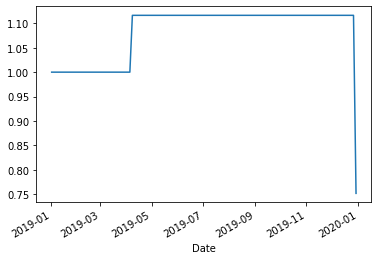

In [48]:
book['acc return'].plot()

In [49]:
#3년

In [50]:
df = yf.download('014130.KS', start = '2017-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [51]:
df['CODE'] = 'SPY'

In [52]:
price_df = df.loc[:,['Adj Close']].copy()

In [53]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [54]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [55]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [56]:
n = 20 #이평선
sigma = 2 #시그마

In [57]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [58]:
bollinger = bollinger_band(price_df, n, sigma)

In [59]:
base_date = '2009-01-02'

In [60]:
sample = bollinger.loc[base_date:]

In [61]:
book = sample[['Adj Close']].copy()

In [62]:
book['trade'] = '' #거래내역 컬럼

In [63]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [64]:
book = create_trade_book(sample)

In [65]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [66]:
book = tradings(sample,book)

In [67]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2017-02-07 00:00:00 long 진입가격 :  6221.32861328125
청산일 :  2017-05-19 00:00:00 long 진입가격 :  6221.32861328125  |  long 청산가격 :  6421.40185546875  | return: 1.0322
진입일 :  2017-06-16 00:00:00 long 진입가격 :  6430.9296875
청산일 :  2017-11-06 00:00:00 long 진입가격 :  6430.9296875  |  long 청산가격 :  4830.34228515625  | return: 0.7511
진입일 :  2017-12-01 00:00:00 long 진입가격 :  4625.50537109375
청산일 :  2018-01-23 00:00:00 long 진입가격 :  4625.50537109375  |  long 청산가격 :  4656.25244140625  | return: 1.0066
진입일 :  2018-04-11 00:00:00 long 진입가격 :  6111.33154296875
청산일 :  2018-04-20 00:00:00 long 진입가격 :  6111.33154296875  |  long 청산가격 :  6693.36279296875  | return: 1.0952
진입일 :  2018-04-30 00:00:00 long 진입가격 :  5830.0166015625
청산일 :  2018-11-06 00:00:00 long 진입가격 :  5830.0166015625  |  long 청산가격 :  4336.13525390625  | return: 0.7438
진입일 :  2018-12-06 00:00:00 long 진입가격 :  4210.0283203125
청산일 :  2019-01-09 00:00:00 long 진입가격 :  4210.0283203125  |  long 청산가격 :  4450.3828125  | return: 1.0571
진입일 :  2019-03-08 00

In [68]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [69]:
print(returns(book))

진입일 :  2017-02-07 00:00:00 long 진입가격 :  6221.32861328125
청산일 :  2017-05-19 00:00:00 long 진입가격 :  6221.32861328125  |  long 청산가격 :  6421.40185546875  | return: 1.0322
진입일 :  2017-06-16 00:00:00 long 진입가격 :  6430.9296875
청산일 :  2017-11-06 00:00:00 long 진입가격 :  6430.9296875  |  long 청산가격 :  4830.34228515625  | return: 0.7511
진입일 :  2017-12-01 00:00:00 long 진입가격 :  4625.50537109375
청산일 :  2018-01-23 00:00:00 long 진입가격 :  4625.50537109375  |  long 청산가격 :  4656.25244140625  | return: 1.0066
진입일 :  2018-04-11 00:00:00 long 진입가격 :  6111.33154296875
청산일 :  2018-04-20 00:00:00 long 진입가격 :  6111.33154296875  |  long 청산가격 :  6693.36279296875  | return: 1.0952
진입일 :  2018-04-30 00:00:00 long 진입가격 :  5830.0166015625
청산일 :  2018-11-06 00:00:00 long 진입가격 :  5830.0166015625  |  long 청산가격 :  4336.13525390625  | return: 0.7438
진입일 :  2018-12-06 00:00:00 long 진입가격 :  4210.0283203125
청산일 :  2019-01-09 00:00:00 long 진입가격 :  4210.0283203125  |  long 청산가격 :  4450.3828125  | return: 1.0571
진입일 :  2019-03-08 00

In [70]:
import matplotlib.pylab as plt

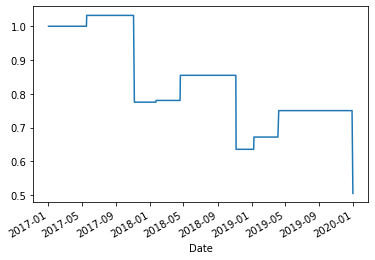

In [71]:
book['acc return'].plot()

In [72]:
#5년

In [73]:
df = yf.download('014130.KS', start = '2015-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [74]:
df['CODE'] = 'SPY'

In [75]:
price_df = df.loc[:,['Adj Close']].copy()

In [76]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [77]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [78]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [79]:
n = 20 #이평선
sigma = 2 #시그마

In [80]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [81]:
bollinger = bollinger_band(price_df, n, sigma)

In [82]:
base_date = '2009-01-02'

In [83]:
sample = bollinger.loc[base_date:]

In [84]:
book = sample[['Adj Close']].copy()

In [85]:
book['trade'] = '' #거래내역 컬럼

In [86]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [87]:
book = create_trade_book(sample)

In [88]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [89]:
book = tradings(sample,book)

In [90]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2015-07-08 00:00:00 long 진입가격 :  8384.5888671875
청산일 :  2015-07-15 00:00:00 long 진입가격 :  8384.5888671875  |  long 청산가격 :  11723.41796875  | return: 1.3982
진입일 :  2015-08-24 00:00:00 long 진입가격 :  10691.7568359375
청산일 :  2015-11-13 00:00:00 long 진입가격 :  10691.7568359375  |  long 청산가격 :  8872.283203125  | return: 0.8298
진입일 :  2016-03-24 00:00:00 long 진입가격 :  12032.091796875
청산일 :  2016-04-04 00:00:00 long 진입가격 :  12032.091796875  |  long 청산가격 :  13636.3720703125  | return: 1.1333
진입일 :  2016-04-29 00:00:00 long 진입가격 :  12409.5712890625
청산일 :  2017-05-19 00:00:00 long 진입가격 :  12409.5712890625  |  long 청산가격 :  6421.40185546875  | return: 0.5175
진입일 :  2017-06-16 00:00:00 long 진입가격 :  6430.9296875
청산일 :  2017-11-06 00:00:00 long 진입가격 :  6430.9296875  |  long 청산가격 :  4830.34228515625  | return: 0.7511
진입일 :  2017-12-01 00:00:00 long 진입가격 :  4625.50537109375
청산일 :  2018-01-23 00:00:00 long 진입가격 :  4625.50537109375  |  long 청산가격 :  4656.25244140625  | return: 1.0066
진입일 :  2018-04-11 00

In [91]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [92]:
print(returns(book))

진입일 :  2015-07-08 00:00:00 long 진입가격 :  8384.5888671875
청산일 :  2015-07-15 00:00:00 long 진입가격 :  8384.5888671875  |  long 청산가격 :  11723.41796875  | return: 1.3982
진입일 :  2015-08-24 00:00:00 long 진입가격 :  10691.7568359375
청산일 :  2015-11-13 00:00:00 long 진입가격 :  10691.7568359375  |  long 청산가격 :  8872.283203125  | return: 0.8298
진입일 :  2016-03-24 00:00:00 long 진입가격 :  12032.091796875
청산일 :  2016-04-04 00:00:00 long 진입가격 :  12032.091796875  |  long 청산가격 :  13636.3720703125  | return: 1.1333
진입일 :  2016-04-29 00:00:00 long 진입가격 :  12409.5712890625
청산일 :  2017-05-19 00:00:00 long 진입가격 :  12409.5712890625  |  long 청산가격 :  6421.40185546875  | return: 0.5175
진입일 :  2017-06-16 00:00:00 long 진입가격 :  6430.9296875
청산일 :  2017-11-06 00:00:00 long 진입가격 :  6430.9296875  |  long 청산가격 :  4830.34228515625  | return: 0.7511
진입일 :  2017-12-01 00:00:00 long 진입가격 :  4625.50537109375
청산일 :  2018-01-23 00:00:00 long 진입가격 :  4625.50537109375  |  long 청산가격 :  4656.25244140625  | return: 1.0066
진입일 :  2018-04-11 00

In [93]:
import matplotlib.pylab as plt

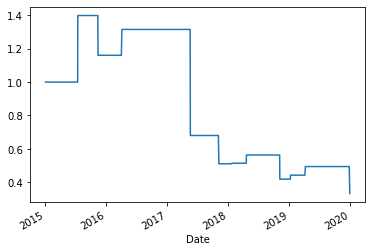

In [94]:
book['acc return'].plot()

In [95]:
#10년

In [96]:
df = yf.download('014130.KS', start = '2009-01-01', end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [97]:
df['CODE'] = 'SPY'

In [98]:
price_df = df.loc[:,['Adj Close']].copy()

In [99]:
price_df['center'] = price_df['Adj Close'].rolling(20).mean() # 20일 이동평균선

In [100]:
# +2 표준편차를 둔 상단 밴드
price_df['ub'] = price_df['center'] + 2 * price_df['Adj Close'].rolling(20).std() 

In [101]:
# -2 표준편차를 둔 하단 밴드
price_df['lb'] = price_df['center'] - 2 * price_df['Adj Close'].rolling(20).std()

In [102]:
n = 20 #이평선
sigma = 2 #시그마

In [103]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['Adj Close'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['Adj Close'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['Adj Close'].rolling(n).std() # 하단 밴드
    return bb

In [104]:
bollinger = bollinger_band(price_df, n, sigma)

In [105]:
base_date = '2009-01-02'

In [106]:
sample = bollinger.loc[base_date:]

In [107]:
book = sample[['Adj Close']].copy()

In [108]:
book['trade'] = '' #거래내역 컬럼

In [109]:
def create_trade_book(sample):
    book = sample[['Adj Close']].copy()
    book['trade'] = ''
    return (book)    

In [110]:
book = create_trade_book(sample)

In [111]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Adj Close'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Adj Close']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Adj Close'] and sample.loc[i, 'Adj Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [112]:
book = tradings(sample,book)

In [113]:
for i in book.index:
    if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
        buy = book.loc[i, 'Adj Close']
        print('진입일 : ',i, 'long 진입가격 : ', buy)
    elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
        sell = book.loc[i, 'Adj Close']
        rtn = (sell - buy) / buy + 1 # 손익 계산
        book.loc[i, 'return'] = rtn
        print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
              sell, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '':     # zero position
        buy = 0.0
        sell = 0.0

진입일 :  2009-11-26 00:00:00 long 진입가격 :  1578.3609619140625
청산일 :  2010-01-11 00:00:00 long 진입가격 :  1578.3609619140625  |  long 청산가격 :  1420.987548828125  | return: 0.9003
진입일 :  2010-06-28 00:00:00 long 진입가격 :  1957.907958984375
청산일 :  2010-07-08 00:00:00 long 진입가격 :  1957.907958984375  |  long 청산가격 :  2430.02783203125  | return: 1.2411
진입일 :  2010-10-04 00:00:00 long 진입가격 :  2193.968017578125
청산일 :  2010-10-26 00:00:00 long 진입가격 :  2193.968017578125  |  long 청산가격 :  2300.42626953125  | return: 1.0485
진입일 :  2010-11-15 00:00:00 long 진입가격 :  2129.167236328125
청산일 :  2011-01-04 00:00:00 long 진입가격 :  2129.167236328125  |  long 청산가격 :  2143.052978515625  | return: 1.0065
진입일 :  2011-02-15 00:00:00 long 진입가격 :  2119.90966796875
청산일 :  2011-03-11 00:00:00 long 진입가격 :  2119.90966796875  |  long 청산가격 :  2263.3974609375  | return: 1.0677
진입일 :  2011-06-16 00:00:00 long 진입가격 :  2314.31201171875
청산일 :  2011-07-21 00:00:00 long 진입가격 :  2314.31201171875  |  long 청산가격 :  2462.427978515625  | return:

In [114]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'Adj Close']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'Adj Close']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [115]:
print(returns(book))

진입일 :  2009-11-26 00:00:00 long 진입가격 :  1578.3609619140625
청산일 :  2010-01-11 00:00:00 long 진입가격 :  1578.3609619140625  |  long 청산가격 :  1420.987548828125  | return: 0.9003
진입일 :  2010-06-28 00:00:00 long 진입가격 :  1957.907958984375
청산일 :  2010-07-08 00:00:00 long 진입가격 :  1957.907958984375  |  long 청산가격 :  2430.02783203125  | return: 1.2411
진입일 :  2010-10-04 00:00:00 long 진입가격 :  2193.968017578125
청산일 :  2010-10-26 00:00:00 long 진입가격 :  2193.968017578125  |  long 청산가격 :  2300.42626953125  | return: 1.0485
진입일 :  2010-11-15 00:00:00 long 진입가격 :  2129.167236328125
청산일 :  2011-01-04 00:00:00 long 진입가격 :  2129.167236328125  |  long 청산가격 :  2143.052978515625  | return: 1.0065
진입일 :  2011-02-15 00:00:00 long 진입가격 :  2119.90966796875
청산일 :  2011-03-11 00:00:00 long 진입가격 :  2119.90966796875  |  long 청산가격 :  2263.3974609375  | return: 1.0677
진입일 :  2011-06-16 00:00:00 long 진입가격 :  2314.31201171875
청산일 :  2011-07-21 00:00:00 long 진입가격 :  2314.31201171875  |  long 청산가격 :  2462.427978515625  | return:

In [116]:
import matplotlib.pylab as plt

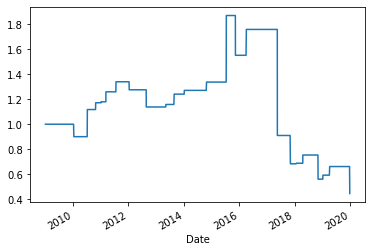

In [117]:
book['acc return'].plot()